In [1]:
import os
import os.path as osp
import numpy as np
import pandas as pd
import torch
import scipy
import scipy.stats
from scipy.signal import find_peaks
from scipy.sparse import csr_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
import pickle
import gffutils
from tqdm import tqdm
import itertools
import coolbox
from coolbox.api import *
import warnings
import sqlite3
import json

warnings.filterwarnings('ignore')

In [2]:
def set_diagonal(mat, value=0):
    if mat.shape[0] - mat.shape[1]:
        raise ValueError(
            'Matrix is not square ({}, {})'.format(mat.shape[0], mat.shape[1])
        )
    l = mat.shape[0]
    idx = np.arange(l)
    mat[idx[:-1], idx[1:]], mat[idx[1:], idx[:-1]] = value, value

    return mat


def load_pred(pred_dir, ct, chrom, pred_len=200, avg_stripe=False):
    file = osp.join(pred_dir, ct, 'prediction_{}_chr{}.npz'.format(ct, chrom))
    temp = np.load(file)['arr_0']
    chrom_len = temp.shape[0]
    prep = np.insert(temp, pred_len, 0, axis=1)
    mat = np.array([
        np.insert(np.zeros(chrom_len+pred_len+1), i, prep[i]) for i in range(chrom_len)
    ])
    summed = np.vstack((
        np.zeros((pred_len, mat.shape[1])), mat
    )).T[:chrom_len+pred_len, :chrom_len+pred_len]
    if avg_stripe:
        summed = (summed + np.vstack((
            np.zeros((pred_len, mat.shape[1])), mat
        ))[:chrom_len+pred_len, :chrom_len+pred_len])/2
    
    pred = set_diagonal(summed[pred_len:-pred_len, pred_len:-pred_len])

    return pred


def load_database(db_file, gtf_file):
    if osp.isfile(db_file):
        db = gffutils.FeatureDB(db_file)
    else:
        print('creating db from raw. This might take a while.')
        db = gffutils.create_db(gtf_file, db_file)
    
    return db

In [3]:
input_dir = '/data/leslie/suny4/processed_input/'
pred_dir = '/data/leslie/suny4/predictions/chromafold/'
ct1 = 'alexia_am_gfp_myc_thelp'
ct2 = 'alexia_am_gfp_myc_nothelp'
chrom = 13
db_file = '/data/leslie/suny4/data/chrom_size/gencode.vM10.basic.annotation.db'

In [145]:
%%time

pred1 = load_pred(pred_dir, ct1, chrom, avg_stripe=True)
pred2 = load_pred(pred_dir, ct2, chrom, avg_stripe=True)

CPU times: user 2.98 s, sys: 1.8 s, total: 4.78 s
Wall time: 4.9 s


In [99]:
def quantile_normalize(preds, offset=2):
    N, H, W = preds.shape
    assert H == W, f'Matrix is not square ({H}, {W})'
    pred_diag = np.column_stack((
        np.array([
            np.pad(np.diagonal(pred, offset=i), (0, i), 'constant') for i in range(offset, 200)
        ]).T.ravel() for pred in preds
    ))
    df, df_mean = pd.DataFrame(pred_diag), pd.DataFrame(np.sort(pred_diag, axis=0)).mean(axis=1)
    df_mean.index += 1
    pred_diag_qn = df.rank(method='min').stack().astype(int).map(df_mean).unstack().values
    pred_diag_qn = pred_diag_qn.T.reshape(N, -1, 200-offset)
    preds_qn = np.zeros_like(preds)
    for i in range(offset, 200):
        idx = np.arange(H - i, dtype=int)
        preds_qn[:, idx, idx+i] = preds_qn[:, idx+i, idx] = pred_diag_qn[:, :H-i, i-offset]
    
    return preds_qn

In [147]:
%%time

preds_qn = quantile_normalize(np.array([pred1, pred2]))
pred1, pred2 = preds_qn[0], preds_qn[1]
pred_diff = pred1 - pred2

CPU times: user 2.82 s, sys: 718 ms, total: 3.54 s
Wall time: 3.55 s


In [7]:
def topdom(pred_mat, window_size=10, cutoff=None):
    if pred_mat.shape[0]-pred_mat.shape[1]:
        raise ValueError(
            'Matrix is not square ({}, {})'.format(pred_mat.shape[0], pred_mat.shape[1])
        )
    pad_mat = np.pad(pred_mat, window_size, mode='constant', constant_values=np.nan)
    dim = pad_mat.shape[0]
    signal = np.array([
        np.nanmean(pad_mat[i-window_size:i, i:i+window_size]) for i in range(dim)
    ][window_size+1: -window_size])
    if cutoff is not None:
        signal[signal<cutoff] = cutoff

    return signal


def region_topdom(pred_mat, window_size=10):
    if pred_mat.shape[0]-pred_mat.shape[1]:
        raise ValueError(
            'Matrix is not square ({}, {})'.format(pred_mat.shape[0], pred_mat.shape[1])
        )
    pad_mat = np.pad(pred_mat, window_size, mode='constant', constant_values=np.nan)
    dim = pad_mat.shape[0]
    signal = np.array([
        np.nanmean(pad_mat[i-window_size:i+window_size, i-window_size:i+window_size]) for i in range(dim)
    ][window_size:-window_size])

    return signal

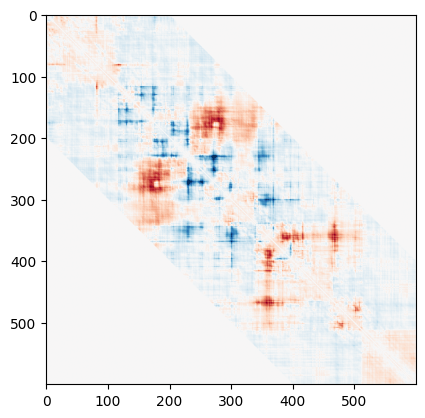

In [105]:
plt.imshow(pred_diff[4200:4800, 4200:4800], cmap='RdBu_r', vmax=2, vmin=-2)
plt.show()

In [121]:
segment = np.arange(4400, 4601, dtype=int)

stripe = np.array([
    np.array([
        pred_diff[i-200:i+1, i], pred_diff[i, i:i+201]
    ]).flatten() for i in segment
])
stripe.shape

(201, 402)

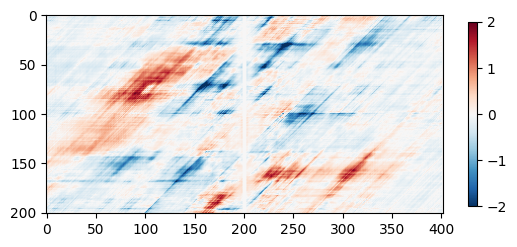

In [133]:
im = plt.imshow(stripe, cmap='RdBu_r', vmax=2, vmin=-2)
plt.colorbar(im, shrink=0.5)
plt.show()

In [138]:
sizes = np.linspace(10, 100, 50, dtype=int)
signals = np.array([topdom(pred_diff, i) for i in tqdm(sizes, position=0)])
signals.shape

100%|██████████| 50/50 [00:36<00:00,  1.36it/s]


(50, 11541)

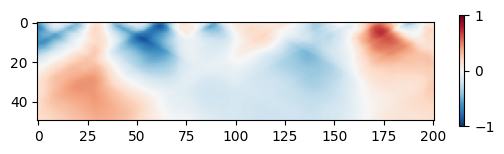

In [139]:
im = plt.imshow(signals[:, 4400:4601], cmap='RdBu_r', vmax=1, vmin=-1)
plt.colorbar(im, shrink=0.3)
plt.show()

In [140]:
def check(pred, bedpe_thresh=99.):
    min_len = len(np.diag(pred, 199))
    all_zval = np.concatenate([np.diag(pred, i)[:min_len] for i in range(1, 200)])
    bin_pred = all_zval.reshape(-1, min_len)
    bin_mask = (bin_pred.sum(0) < np.percentile(bin_pred.sum(0), 1))
    zval_cutoff = np.percentile(all_zval, bedpe_thresh) if bedpe_thresh >= 90 else bedpe_thresh
    
    return zval_cutoff

In [148]:
check(pred1), check(pred2)

(1.8368262881040571, 1.836165912151334)

In [143]:
def check2(pred1, pred2, bedpe_thresh=99.):
    min_len = len(np.diag(pred1, 199))
    all_zval = np.concatenate((
        np.concatenate([np.diag(pred1, i)[:min_len] for i in range(1, 200)]),
        np.concatenate([np.diag(pred2, i)[:min_len] for i in range(1, 200)])
    ))
    bedpe_thresh = np.percentile(all_zval, bedpe_thresh)
    
    return check(pred1, bedpe_thresh), check(pred2, bedpe_thresh)

In [144]:
check2(pred1, pred2)

(1.8365121054649383, 1.8365121054649383)

In [150]:
pred1.shape[0]

11542

In [156]:
a = np.array([100, 2, 3, 4, 5])
a / np.linalg.norm(a)

array([0.99731089, 0.01994622, 0.02991933, 0.03989244, 0.04986554])

In [157]:
b = np.array([5, 4, 3, 2, 1])
a @ b

530